In [ ]:
!pip install datamaestro

In [ ]:
import logging
import re
from pathlib import Path
from tqdm import tqdm
import numpy as np

from datamaestro import prepare_dataset
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
class FolderText(Dataset):
    """Dataset basé sur des dossiers (un par classe) et fichiers"""

    def __init__(self, classes, folder: Path, tokenizer, load=False):
        self.tokenizer = tokenizer
        self.files = []
        self.filelabels = []
        self.labels = {}
        for ix, key in enumerate(classes):
            self.labels[key] = ix

        for label in classes:
            for file in (folder / label).glob("*.txt"):
                self.files.append(file.read_text() if load else file)
                self.filelabels.append(self.labels[label])

    def __len__(self):
        return len(self.filelabels)

    def __getitem__(self, ix):
        s = self.files[ix]
        return self.tokenizer(s if isinstance(s, str) else s.read_text()), self.filelabels[ix]

In [ ]:
def load_glove_embeddings(file_path, embedding_size):
    words = []
    embeddings = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            words.append(word)
            embeddings.append(vector)
    return words, np.vstack(embeddings)

In [ ]:
def load_aclimdb_dataset(dataset_path):
    dataset_path = Path(dataset_path)
    if not dataset_path.is_dir():
        raise ValueError(f"Path {dataset_path} is not a valid directory")

    train_path = dataset_path / "train"
    test_path = dataset_path / "test"
    classes = ["pos", "neg"]  # 类别文件夹
    return {
        "train": {
            "path": train_path,
            "classes": classes,
        },
        "test": {
            "path": test_path,
            "classes": classes,
        },
    }

In [ ]:
def get_imdb_data(embedding_size=50):
    """Renvoie l'ensemble des donnéees nécessaires pour l'apprentissage

    - dictionnaire word vers ID  单词到索引的字典
    - embeddings (Glove)  词嵌入矩阵
    - DataSet (FolderText)
      - train_ds  训练集的 FolderText 对象
      - test_ds  测试集的 FolderText 对象

    """
    WORDS = re.compile(r"\S+")

    # words, embeddings = prepare_dataset('edu.stanford.glove.6b.%d' % embedding_size).load()
    glove_file = "/content/glove.6B.50d.txt"
    words, embeddings = load_glove_embeddings(glove_file, embedding_size=50)

    OOVID = len(words)
    words.append("__OOV__")

    word2id = {word: ix for ix, word in enumerate(words)}
    embeddings = np.vstack((embeddings, np.zeros(embedding_size)))

    def tokenizer(t):
        return [word2id.get(x, OOVID) for x in re.findall(WORDS, t.lower())]

    logging.info("Loading embeddings")

    logging.info("Get the IMDB dataset")
    # ds = prepare_dataset("edu.stanford.aclimdb")
    ds = load_aclimdb_dataset("/content/aclImdb")

    train_ds = FolderText(ds["train"]["classes"], Path(ds["train"]["path"]), tokenizer, load=False)
    test_ds = FolderText(ds["test"]["classes"], Path(ds["test"]["path"]), tokenizer, load=False)

    # return word2id, embeddings, FolderText(ds.train.classes, ds.train.path, tokenizer, load=False), FolderText(ds.test.classes, ds.test.path, tokenizer, load=False)
    return word2id, embeddings, train_ds, test_ds

In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip

! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar -xvf aclImdb_v1.tar.gz

流式输出内容被截断，只能显示最后 5000 行内容。
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/44954_0.txt
aclImdb/train

# TODO

In [ ]:
# 加载数据 与 模型训练
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
word2id, embeddings, train_data, test_data = get_imdb_data()

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    自定义的 collate 函数，用于处理批次内的文本长度不一致问题。
    """
    texts, labels = zip(*batch)
    # 填充文本序列到批次内的最大长度
    texts = [torch.tensor(text) for text in texts]
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)  # 0 表示填充值
    labels = torch.tensor(labels)  # 转为张量
    return padded_texts, labels

# 使用自定义的 collate_fn 创建数据加载器
batch_size = 32  # 批大小
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Question 1 : Simple Linear Model

In [ ]:
# Question 1
# 简单线性模型
class SimpleLinearModel(nn.Module):
    def __init__(self, embedding_matrix):   # TODO：是不是需要加入隐藏层？
        super(SimpleLinearModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.linear = nn.Linear(embedding_matrix.shape[1], 2)   # 两个类别 pos 或者 neg

    def forward(self, x):
        embedded = self.embedding(x)
        embedded_mean = embedded.mean(dim=1)
        return self.linear(embedded_mean)

In [ ]:
# 训练模型
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
# 评估模型
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
# 模型训练
model = SimpleLinearModel(embeddings).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 开始训练
for epoch in range(5):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    eval_correct = evaluate_model(model, test_loader, device)
    print(f"Epoch: {epoch+1},\t Train_loss: {train_loss},\t Accuracy: {eval_correct}\n")

100%|██████████| 782/782 [00:07<00:00, 106.93it/s]


Epoch: 1,	 Train_loss: 0.6906595005251258,	 Accuracy: 0.61032



100%|██████████| 782/782 [00:05<00:00, 134.68it/s]


Epoch: 2,	 Train_loss: 0.6804130597187735,	 Accuracy: 0.6364



100%|██████████| 782/782 [00:06<00:00, 127.33it/s]


Epoch: 3,	 Train_loss: 0.6730725222536366,	 Accuracy: 0.6406



100%|██████████| 782/782 [00:09<00:00, 86.77it/s]


Epoch: 4,	 Train_loss: 0.6674070420777402,	 Accuracy: 0.62312



100%|██████████| 782/782 [00:05<00:00, 137.58it/s]

Epoch: 5,	 Train_loss: 0.6618385126676096,	 Accuracy: 0.62716



## Question 2 : Attention simple

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 简单注意力模型
class SimpleAttentionModel(nn.Module):
    def __init__(self, embedding_matrix):
        super(SimpleAttentionModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.query = nn.Parameter(torch.randn(embedding_dim))
        self.linear = nn.Linear(embedding_dim, 2)

    def forward(self, x):
        # 嵌入查找
        embedded = self.embedding(x)    # (batch_size, seq_len, embedding_dim)

        # 注意力分数
        attention_weights = torch.matmul(embedded, self.query)   # (batch_size, seq_len)
        alphas = F.softmax(attention_weights, dim=1)

        # 根据注意力权重加权嵌入表示
        context = torch.sum(embedded * alphas.unsqueeze(-1), dim=1)   # (batch_size, embedding_dim)

        # 将加权表示传入分类器
        output = self.linear(context)

        return output, alphas

In [ ]:
def visualize_attention(inputs, alphas, word2id):
    # 将 ID 转换为词语
    id2word = {v: k for k, v in word2id.items()}
    id2word[len(word2id) - 1] = "__OOV__"  # 为 OOV 添加映射

    # 转换 ID 到单词
    words = [[id2word.get(idx.item(), "__OOV__") for idx in sentence] for sentence in inputs]

    for sentence, attention in zip(words, alphas):
        print("Sentence:", " ".join(sentence))
        print("Attention:", attention.tolist())
        print()


In [ ]:
# 计算注意力分布的熵
def compute_entropy(alphas):
    # 避免 log(0) 的情况，定义一个很小的 epsilon
    epsilon = 1e-10
    entropy = -torch.sum(alphas * torch.log(alphas + epsilon), dim=1)  # 对每个序列计算熵
    return entropy

In [ ]:
# 训练模型 计算注意力熵的分布
def train_model_with_entropy(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    attention_entropies = []
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, alphas = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # visualize_attention(inputs, alphas, word2id)

        entropies = compute_entropy(alphas)
        attention_entropies.extend(entropies.tolist())

        total_loss += loss.item()

    return total_loss / len(train_loader), attention_entropies

In [ ]:
# 评估模型 计算准确率
def evaluate_model_with_entropy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, alphas = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

100%|██████████| 782/782 [00:05<00:00, 141.70it/s]


Epoch: 1,	 Train_loss: 0.6862,	 Accuracy: 0.5780



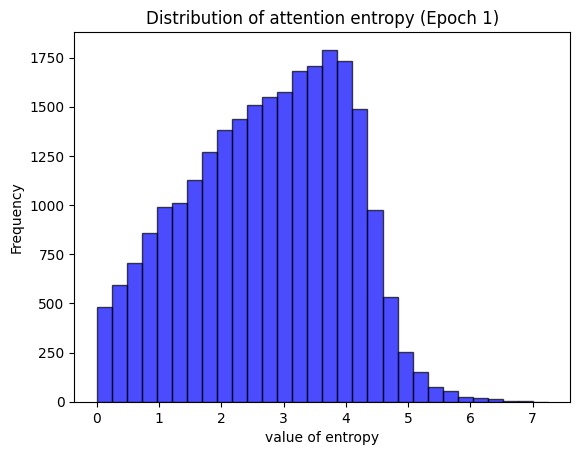

100%|██████████| 782/782 [00:08<00:00, 93.19it/s] 


Epoch: 2,	 Train_loss: 0.6647,	 Accuracy: 0.6260



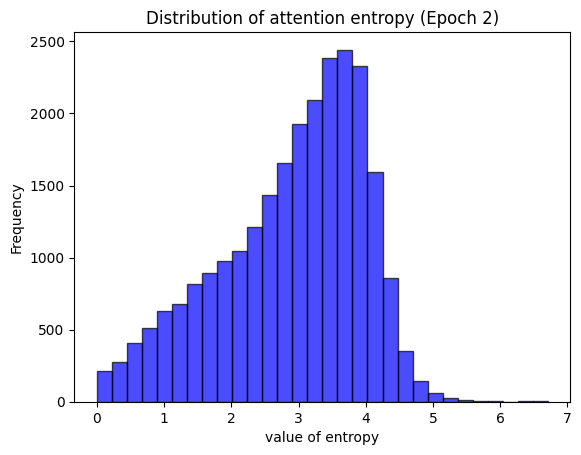

100%|██████████| 782/782 [00:08<00:00, 95.40it/s]


Epoch: 3,	 Train_loss: 0.6308,	 Accuracy: 0.6677



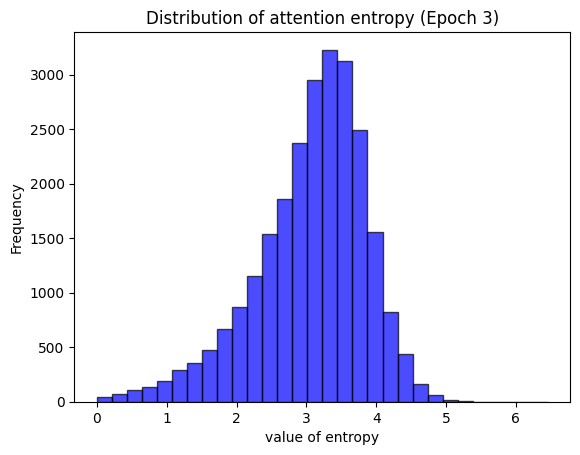

100%|██████████| 782/782 [00:05<00:00, 139.82it/s]


Epoch: 4,	 Train_loss: 0.6047,	 Accuracy: 0.6864



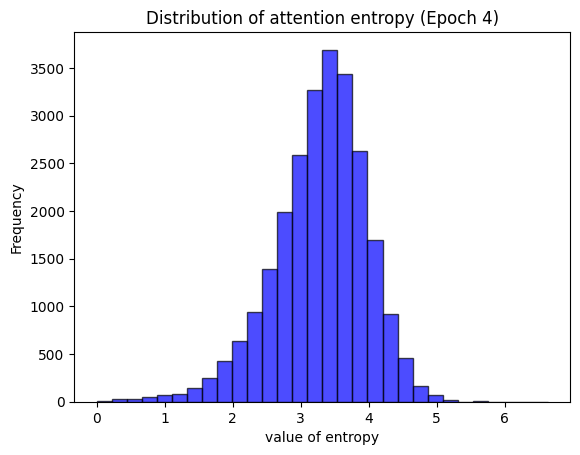

100%|██████████| 782/782 [00:05<00:00, 143.04it/s]


Epoch: 5,	 Train_loss: 0.5749,	 Accuracy: 0.7146



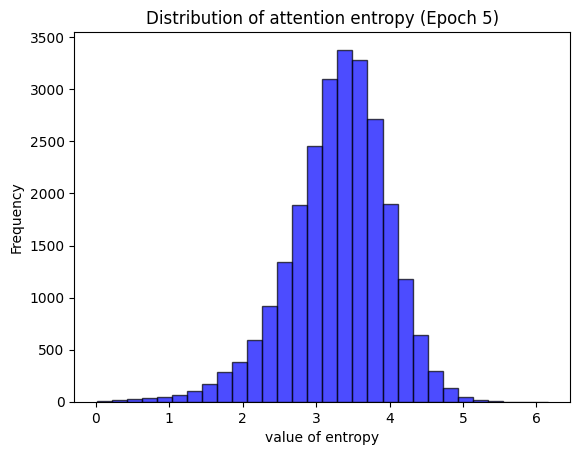

In [ ]:
# 模型训练 绘制注意力熵的直方图
model = SimpleAttentionModel(embeddings).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    train_loss, attention_entropies = train_model_with_entropy(model, train_loader, criterion, optimizer, device)
    eval_correct = evaluate_model_with_entropy(model, test_loader, device)

    print(f"Epoch: {epoch+1},\t Train_loss: {train_loss:.4f},\t Accuracy: {eval_correct:.4f}\n")

    plt.hist(attention_entropies, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribution of attention entropy (Epoch {epoch+1})")
    plt.xlabel("value of entropy")
    plt.ylabel("Frequency")
    plt.show()

## Question 3 : Question and Value



In [ ]:
# 查询 q 依赖于文本本身的 AttentionModel
class AttentionModel(nn.Module):
    def __init__(self, embedding_matrix):
        super(AttentionModel, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.linear_q = nn.Linear(self.embedding_dim, self.embedding_dim)        # 从 t_m 计算 q(t_m)
        self.embedding_transform = nn.Linear(self.embedding_dim, self.embedding_dim)   # 可学习的嵌入变换 v(x)
        self.classify_linear = nn.Linear(self.embedding_dim, 2)

    def forward(self, x):
        embedded = self.embedding(x)   # (batch_size, seq_len, embedding_dim)
        t_m = embedded.mean(dim=1)    # (batch_size, embedding_dim)
        q = self.linear_q(t_m)      # (batch_size, embedding_dim)

        attention_weights = torch.matmul(embedded, q.unsqueeze(-1)).squeeze(-1)  # (batch_size, seq_len)
        alphas = F.softmax(attention_weights, dim=1)

        transform_embedded = self.embedding_transform(embedded)          # (batch_size, seq_len, embedding_dim)
        t_hat = torch.sum(alphas.unsqueeze(-1) * transform_embedded, dim=1)  # (batch_size, embedding_dim)

        output = self.classify_linear(t_hat)
        return output, alphas


100%|██████████| 782/782 [00:07<00:00, 105.34it/s]


Epoch: 1,	 Train_loss: 0.5178,	 Accuracy: 0.7779



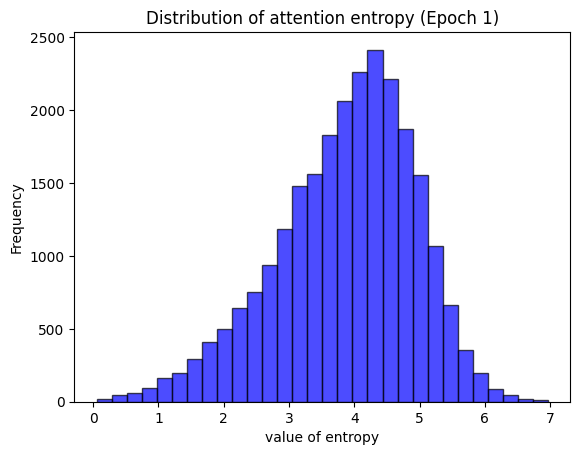

100%|██████████| 782/782 [00:09<00:00, 83.32it/s] 


Epoch: 2,	 Train_loss: 0.4651,	 Accuracy: 0.7901



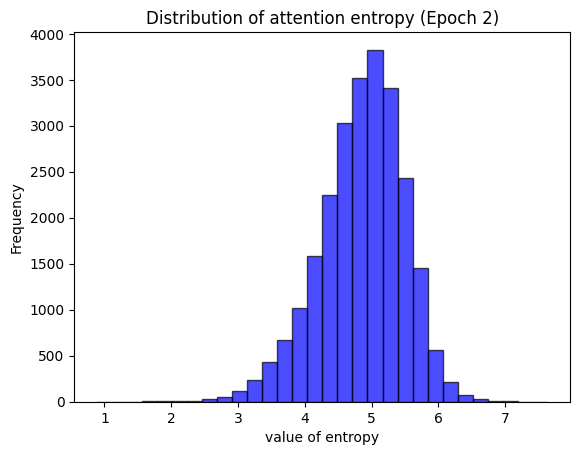

100%|██████████| 782/782 [00:08<00:00, 91.61it/s]


Epoch: 3,	 Train_loss: 0.4550,	 Accuracy: 0.7818



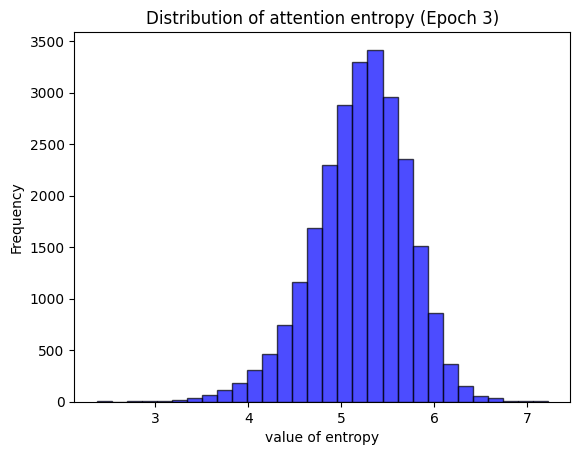

100%|██████████| 782/782 [00:06<00:00, 123.07it/s]


Epoch: 4,	 Train_loss: 0.4535,	 Accuracy: 0.7938



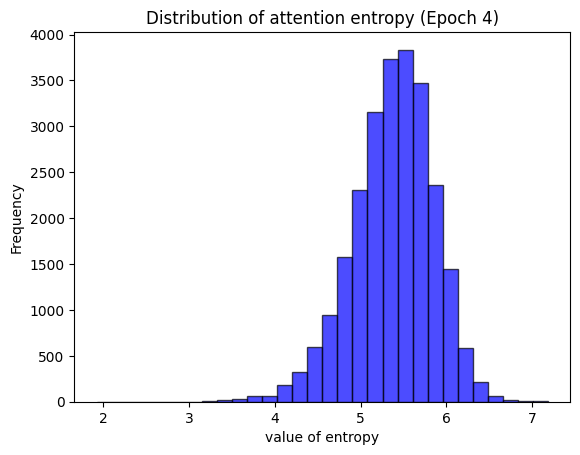

100%|██████████| 782/782 [00:05<00:00, 134.82it/s]


Epoch: 5,	 Train_loss: 0.4520,	 Accuracy: 0.7957



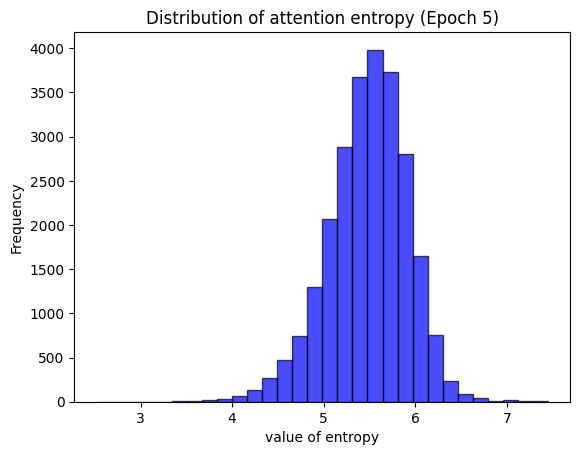

In [ ]:
# 模型训练 绘制注意力熵的直方图
model = AttentionModel(embeddings).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    train_loss, attention_entropies = train_model_with_entropy(model, train_loader, criterion, optimizer, device)
    eval_correct = evaluate_model_with_entropy(model, test_loader, device)

    print(f"Epoch: {epoch+1},\t Train_loss: {train_loss:.4f},\t Accuracy: {eval_correct:.4f}\n")

    plt.hist(attention_entropies, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribution of attention entropy (Epoch {epoch+1})")
    plt.xlabel("value of entropy")
    plt.ylabel("Frequency")
    plt.show()

## Question 4 : Modèles contextuels et attention

- LSTM

In [ ]:
class AttentionModel_LSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers=1, bidirectional=False):
        super(AttentionModel_LSTM, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]
        self.hidden_dim = hidden_dim
        self.num_directions = 2 if bidirectional else 1

        # Embedding 层
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)

        # LSTM层
        self.lstm = nn.LSTM(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = bidirectional
        )

        # 注意力相关层
        self.attention_linear = nn.Linear(self.hidden_dim * self.num_directions, 1)   # 使用另一种注意力分数计算方式（更常用，计算复杂）
        self.embedding_transform = nn.Linear(self.hidden_dim * self.num_directions, self.hidden_dim * self.num_directions)  # 可学习嵌入变换

        # 最终分类层
        self.classify_linear = nn.Linear(self.hidden_dim * self.num_directions, 2)

    def forward(self, x):
        # Embedding 层
        embedded = self.embedding(x)      # (batch_size, seq_len, embedding_dim)

        # LSTM 层
        lstm_output, _ = self.lstm(embedded)  # (batch_size, seq_len, embedding_dim * num_directions)

        # 注意力层
        attention_weights = self.attention_linear(lstm_output).squeeze(-1)  # (batch_size, seq_len)
        alphas = F.softmax(attention_weights, dim=1)      # (batch_size, seq_len)

        # 加权得到上下文表示 t_hat
        t_hat = torch.sum(alphas.unsqueeze(-1) * lstm_output, dim=1)   # (batch_size, hidden_dim * num_directions)

        # 最终分类
        output = self.classify_linear(t_hat)    # (batch_size, num_classes=2)

        return output, alphas

In [ ]:
# 模型训练 绘制注意力熵的直方图
hidden_dim = 128

model = AttentionModel_LSTM(embeddings, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    train_loss, attention_entropies = train_model_with_entropy(model, train_loader, criterion, optimizer, device)
    eval_correct = evaluate_model_with_entropy(model, test_loader, device)

    print(f"Epoch: {epoch+1}\t Train_loss: {train_loss:.4f}\t Accuracy: {eval_correct:.4f}\n")

    plt.hist(attention_entropies, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribution of attention entropy (Epoch {epoch+1})")
    plt.xlabel("value of entropy")
    plt.ylabel("Frequency")
    plt.show()

- GRU

In [ ]:
class AttentionModel_GRU(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers=1, bidirectional=False):
        super(AttentionModel_GRU, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]
        self.hidden_dim = hidden_dim
        self.num_directions = 2 if bidirectional else 1

        # Embedding 层
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)

        # GRU 层
        self.gru = nn.GRU(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = bidirectional
        )

        # 注意力相关层
        self.attention_linear = nn.Linear(self.hidden_dim * self.num_directions, 1)   # 使用另一种注意力分数计算方式（更常用，计算复杂）
        self.embedding_transform = nn.Linear(self.hidden_dim * self.num_directions, self.hidden_dim * self.num_directions)  # 可学习嵌入变换

        # 最终分类层
        self.classify_linear = nn.Linear(self.hidden_dim * self.num_directions, 2)

    def forward(self, x):
        # Embedding 层
        embedded = self.embedding(x)      # (batch_size, seq_len, embedding_dim)

        # GRU 层
        gru_output, _ = self.gru(embedded)  # (batch_size, seq_len, embedding_dim * num_directions)

        # 注意力层
        attention_weights = self.attention_linear(gru_output).squeeze(-1)  # (batch_size, seq_len)
        alphas = F.softmax(attention_weights, dim=1)      # (batch_size, seq_len)

        # 加权得到上下文表示 t_hat
        t_hat = torch.sum(alphas.unsqueeze(-1) * gru_output, dim=1)   # (batch_size, hidden_dim * num_directions)

        # 最终分类
        output = self.classify_linear(t_hat)    # (batch_size, num_classes=2)

        return output, alphas

In [ ]:
# 模型训练 绘制注意力熵的直方图
hidden_dim = 128

model = AttentionModel_GRU(embeddings, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    train_loss, attention_entropies = train_model_with_entropy(model, train_loader, criterion, optimizer, device)
    eval_correct = evaluate_model_with_entropy(model, test_loader, device)

    print(f"Epoch: {epoch+1}\t Train_loss: {train_loss:.4f}\t Accuracy: {eval_correct:.4f}\n")

    plt.hist(attention_entropies, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribution of attention entropy (Epoch {epoch+1})")
    plt.xlabel("value of entropy")
    plt.ylabel("Frequency")
    plt.show()

## Question 5 : Entropy

In [ ]:
# 训练模型 加入熵正则化项
def train_model_with_entropy_reg(model, train_loader, criterion, optimizer, device, lambda_entropy=0.01):
    model.train()
    total_loss = 0
    attention_entropies = []
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, alphas = model(inputs)

        optimizer.zero_grad()
        class_loss = criterion(outputs, labels)
        entropies = compute_entropy(alphas)
        loss = class_loss + lambda_entropy * entropies
        loss.backward()
        optimizer.step()

        # visualize_attention(inputs, alphas, word2id)

        attention_entropies.extend(entropies.tolist())

        total_loss += loss.item()

    return total_loss / len(train_loader), attention_entropies

In [ ]:
# 模型训练 绘制注意力熵的直方图
hidden_dim = 128
lambda_entropy = 0.01

model = AttentionModel_LSTM(embeddings, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    train_loss, attention_entropies = train_model_with_entropy_reg(model, train_loader, criterion, optimizer, device, lambda_entropy)
    eval_correct = evaluate_model_with_entropy(model, test_loader, device)

    print(f"Epoch: {epoch+1}\t Train_loss: {train_loss:.4f}\t Accuracy: {eval_correct:.4f}\n")

    plt.hist(attention_entropies, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribution of attention entropy (Epoch {epoch+1})")
    plt.xlabel("value of entropy")
    plt.ylabel("Frequency")
    plt.show()